In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random

In [2]:
import networkx as nx

In [3]:
random.seed(42)

In [4]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [5]:
dataset.columns=['Index','Source','Target']

In [6]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [7]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

In [8]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [9]:
n_nodes

98343

In [10]:
category_file = 'wiki-topcats-categories.txt'

In [11]:
categories = {v: [] for v in unique_nodes}
lost = []
with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        for node in nodes:
            try:
                categories[int(node)].append(category)
            except:
                lost.append(int(node))

In [12]:
categories_filtered = {}
for n in categories.keys():
    try:
        rand_category = random.choice(categories[n])
        categories_filtered[n] = rand_category
    except:
        categories_filtered[n] = None

### Creating the graph with Networkx

In [13]:
G = nx.Graph()

In [14]:
for row in dataset.iterrows():
    G.add_edge(row[1][0], row[1][1], capacity=1)

In [15]:
def add_categories(my_category, G):
    for i in my_category.keys():
        G.nodes[i]['category']=my_category[i]
    return G

In [16]:
add_categories(categories_filtered, G)

## RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

- Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

#### Make the graph undirected

In [17]:
H = G.to_undirected()

#### Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

In [18]:
def get_subgraph(G, c1, c2):
    new_graph = G.copy()
    for i in list(new_graph.nodes):
        if new_graph.nodes[i]['category']!=c1 and new_graph.nodes[i]['category']!=c2:
            new_graph.remove_node(i)
    return new_graph

In [19]:
H = get_subgraph(H, 'American_television_actors', 'Films_based_on_novels')
H.number_of_edges()

721

## Functions

In [20]:
class BreakException(Exception):
    pass

def path_not_found():
    raise BreakException()

def shortest_path(g, u, v):
    
    '''
    It is a "BFS" method and return the first path with minimum distance from u to v 
    
    '''
    if u == v:
        return 'same node'  
    
    visited = [] #list of visited nodes
    queue = [[u]] #queue structure
    
    visited.append(u) #add u to visited list
    
    nodes = [] #list of nodes --> path
    
    #calculate all paths with n distance
    #when i have v in nodes return nodes
    while queue:
        s = queue.pop(0)

        for neighbour in g[s[-1]]:
            if neighbour not in visited:
                nodes = list(s)
                nodes.append(neighbour)
                queue.append(nodes)
                visited.append(neighbour)
                
                if neighbour == v:
                    return nodes
                
    return path_not_found()

In [21]:
def find_paths(g, u, v):
    
    '''
    1. Find the shortest path
    2. Remove a random edge of the s.p. from the graph
    3. Repeat 1-2 until there are no paths
    '''
    
    graph = g.copy()
    
    paths = []
    
    while True:
        try:
            path = shortest_path(graph, u, v)
        except BreakException:
            break

        paths.append(path)
        index = random.choice(range(1, len(path)))
        graph.remove_edge(path[index-1], path[index])    
                
    return paths   

In [72]:
def simple_min_cut(g, u, v, starter):
    
    '''
    1. Chose one path from u to v
    2. Remove all edges of the path
    3. Reapet 1 and 2 until there's no path
    4. return the number of path found
    '''

    #print(f'random_path: {starter}')
    index=1
    
    my_g = g.copy()
    for j in range(1, len(starter)):
        my_g.remove_edge(starter[j-1], starter[j])
        #print(f'{index} removed: {starter[j-1]}, {starter[j]}')

    while True:
        try:
            nodes_list = shortest_path(my_g, u, v)
            #print('----')
        except BreakException:
            #print(f'Another path not found! MinCut: {index}')
            break

        index+=1
        for j in range(1, len(nodes_list)):
            my_g.remove_edge(nodes_list[j-1], nodes_list[j])
            #print(f'{index} removed: {nodes_list[j-1]}, {nodes_list[j]}')

    return index

In [24]:
def augmented_min_cut(g, u, v):
    
    '''
    1) if u and v are the same node -> return 'same node'
    2) if deg of u or v is 1 or 0 -> return 1 or 0
    3) paths = call find_paths to calculate different paths
    4) if paths have just one path -> return 1
    5) use simple_min_cut for each path in paths
    6) return the max of the min cuts
    '''

    if u == v:
        return 'Same node'
    
    deg_u = g.degree(u)
    deg_v = g.degree(v)
    
    if deg_u == 1 or deg_v == 1:
        return 1
    
    if deg_u == 0 or deg_v == 0:
        return 0

    paths = find_paths(g, u, v)
    print('Starter Paths: ', paths)
    lenght = len(paths)
    if lenght == 1:
        return 1
    results = []
    
    for i in range(lenght):
        index = simple_min_cut(g, u, v, paths[i]) 
        results.append(index)
    
    print('All min-cut: ', results)
    return max(results)

The following solution is based on the Max-Flow Min-Cut method.

### Simple Min-Cut
    1. Chose one path from u to v
    2. Remove all edges of the path
    3. Reapet 1 and 2 until there's no path
    4. return the number of path found
### Augmented Simple Min-Cut
    1. if u and v are the same node -> return 'same node'
    2. if deg of u or v is 1 or 0 -> return 1 or 0
    3. paths = call find_paths to calculate different paths
    4. if paths have just one path -> return 1
    5. use simple_min_cut for each path in paths
    6. return the max of the min cuts
### Find Paths
    1. Find the shortest path
    2. Remove a random edge of the s.p. from the graph
    3. Repeat 1-2 until there are no paths
    
#### Observations:
    1. For this case the simple_min_cut has the best trade-off Speed-Accuracy.
    2. The Augmented Min-Cut is more accurate.
    3. Let m the Min-Cut, u and v two nodes of the Graph G, we have:
$$m \in [0, max(deg(u), deg(v))]$$

In [26]:
subgraph = H.copy()

#### Random Choice

In [27]:
def find_two_random_nodes(g):
    while True:
        u = random.choice(list(g.nodes()))
        v = random.choice(list(g.nodes()))
        try:
            sp = shortest_path(g, u, v)
            min_cut = simple_min_cut(g, u, v, sp)
            return u,v
        except:
            continue

In [34]:
u,v = find_two_random_nodes(subgraph)
u,v

(1165146, 1165415)

In [35]:
%%time
sp = shortest_path(subgraph, u, v)
simple_min_cut(subgraph, u, v, sp)

Wall time: 9.97 ms


2

In [50]:
%%time
augmented_min_cut(subgraph, u, v)

Starter Paths:  [[1165146, 1061503, 1165415], [1165146, 1061503, 1163674, 1163615, 1165415]]
All min-cut:  [2, 2]
Wall time: 35.9 ms


2

In [46]:
%%time
augmented_min_cut(subgraph, u, v)

Starter Paths:  [[1165146, 1061503, 1165415], [1165146, 1163691, 1061592, 1165429, 1061503, 1165415], [1165146, 1163691, 1165652, 1165448, 1163674, 1061503, 1165415], [1165146, 1163691, 1165652, 1165448, 1165227, 1061503, 1165415], [1165146, 1163691, 402241, 1058080, 1163811, 1163674, 1163615, 1165415], [1165146, 1163691, 1165652, 1165448, 1165227, 1061503, 1165374, 1163907, 1163615, 1165415], [1165146, 1163691, 402241, 1163925, 1165166, 1165321, 1170178, 1163907, 1163615, 1165415], [1165146, 1165286, 1161081, 1165344, 1165303, 1165662, 1065580, 1163761, 1163615, 1165415], [1165146, 1165286, 1161081, 1165344, 1165303, 1165662, 1165374, 1163907, 1163615, 1165415], [1165146, 1165286, 1161081, 1165344, 1165303, 1165324, 1165217, 1163907, 1163615, 1165415], [1165146, 1165286, 1161081, 1165344, 1163736, 1061244, 1061568, 1163907, 1163615, 1165415], [1165146, 1165286, 1165726, 1163688, 1163667, 1165321, 1170178, 1163907, 1163615, 1165415], [1165146, 1163691, 1165652, 1165342, 1163929, 105964

2

In [37]:
%%time
cut_value = nx.minimum_cut(subgraph, u, v)[0]
cut_value

Wall time: 25.9 ms


2

#### Exemple 1

In [51]:
u=1061503
v=1165662

In [52]:
%%time
sp = shortest_path(subgraph, u, v)
simple_min_cut(subgraph, u, v, sp)

Wall time: 11 ms


3

In [55]:
%%time
augmented_min_cut(subgraph, u, v)

Starter Paths:  [[1061503, 1165303, 1165662], [1061503, 1165374, 1165662], [1061503, 1165374, 1165324, 1165303, 1165662], [1061503, 1163674, 1163615, 1163761, 1065580, 1165662]]
All min-cut:  [3, 3, 3, 3]
Wall time: 50.9 ms


3

In [56]:
%%time
cut_value = nx.minimum_cut(subgraph, u, v)[0]
cut_value

Wall time: 61.8 ms


3

### Visualization of find_path
nodes:

    u = 1061503
    v = 1165662

In [455]:
a = find_paths(subgraph, u, v)

In [457]:
b = []
for i in a:
    for j in i:
        b.append(j)
b = set(b)

In [458]:
reduced_graph = subgraph.copy()
for i in list(subgraph.nodes):
    if i in b:
        pass
    else:
        reduced_graph.remove_node(i)

In [459]:
node_sizes = [20*len(reduced_graph.edges(n)) for n in reduced_graph.nodes()]

color_map = []
for node in reduced_graph:
    if node == u or node == v:
        color_map.append('red')
    else: 
        color_map.append('green')

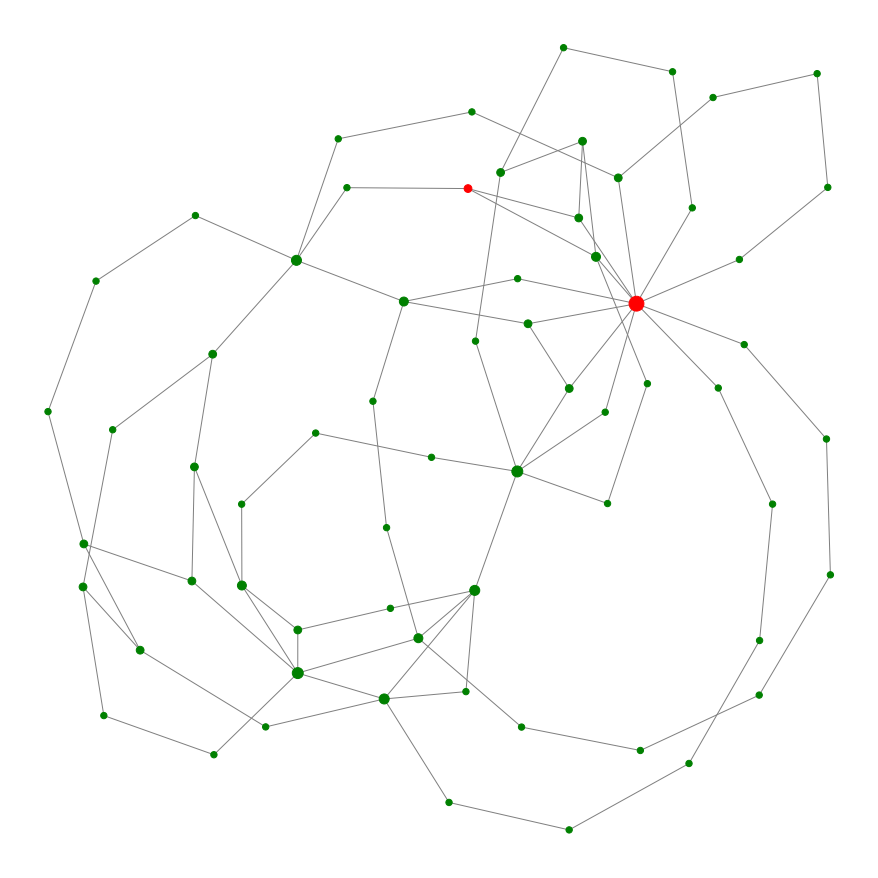

In [460]:
plt.figure(1, figsize=(12,12))
nx.draw_kamada_kawai(reduced_graph, node_size=(node_sizes), node_color=color_map, with_labels=False, edge_color='gray') 
#--> verticalalignment='bottom', font_size = 10
plt.show()

## Why Augmented Min Cut

In [57]:
my_g = nx.Graph()

In [58]:
my_g.add_edge(1, 2)
my_g.add_edge(2, 3)
my_g.add_edge(3, 4)
my_g.add_edge(2, 5)
my_g.add_edge(5, 6)
my_g.add_edge(6, 7)
my_g.add_edge(7, 4)
my_g.add_edge(4, 3)
my_g.add_edge(1, 8)
my_g.add_edge(8, 9)
my_g.add_edge(9, 10)
my_g.add_edge(10, 11)
my_g.add_edge(11, 3)

In [59]:
my_g = my_g.to_undirected()

In [70]:
my_color_map = []
for node in my_g:
    if node == 1 or node == 4:
        my_color_map.append('yellow')
    else: 
        my_color_map.append('orange')

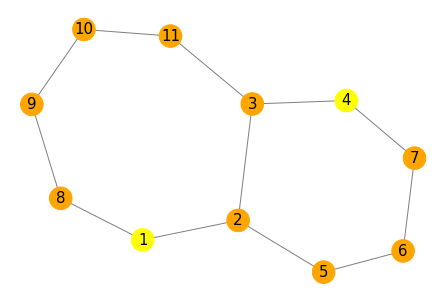

In [71]:
nx.draw(my_g, node_size=510, node_color=my_color_map, with_labels=True, verticalalignment='center', font_size = 15, edge_color='gray')

In [135]:
%%time
sp_e = shortest_path(my_g, 1, 4)
simple_min_cut(my_g, 1, 4, sp_e)

Wall time: 0 ns


1

In [136]:
%%time
augmented_min_cut(my_g, 1, 4)

[[1, 2, 3, 4], [1, 2, 5, 6, 7, 4], [1, 8, 9, 10, 11, 3, 4]]
[1, 2, 2]
Wall time: 0 ns


2

This was an example of how the "augmented simple min cut" helps us to find the correct answer.